In [4]:
import numpy as np
from qutip import *
import dask
from dask import delayed
import dask.bag as db
from dask.distributed import Client, LocalCluster,progress
from tqdm import tqdm
import pandas as pd
import importlib
import functions_fbq
importlib.reload(functions_fbq)
from functions_fbq import *
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from figurestyle import *
# figure_features()

In [204]:
def eigensystem_fbq_odd(Ec,Eo,Ej,e_S0,phi_ext, N = 200, eigvals = 0):
    # EIGENVALUES AND EIGENSTATES OF THE FERMIONIC-BOSONIC QUBIT 

    n_zpf = (Ej/32/Ec)**0.25
    phi_ZPF = (2 * Ec / Ej) ** 0.25

    N_op  = 1j *n_zpf * (destroy(N).dag() - destroy(N))
    phi_op= phi_ZPF * (destroy(N).dag() + destroy(N))
    delta = phi_op - phi_ext

    e_x = e_SO[0]
    e_y = e_SO[1]
    e_z = e_SO[2]

    H = 4*Ec*tensor(N_op**2,qeye(2)) + Ej*tensor(qeye(N) - delta.cosm(),qeye(2)) + Eo*tensor(phi_op.cosm(),qeye(2)) - e_z*tensor(phi_op.sinm(),sigmaz())
    evals,ekets=H.eigenstates(eigvals=eigvals)
    return evals,ekets

In [205]:
# create a matrix of dimension N x N with a value -1 in the second diagonal and 1 in the minus first diagonal and 0 elsewhere and obtained not as a np.array
def sinphi_op(N):
    return Qobj(-np.diag(np.ones(2*N),-1) + np.diag(np.ones(2*N),1))/2/1j

def cosphi_op(phi_ext,N):
    return Qobj(np.diag(np.ones(2*N),-1) + np.diag(np.ones(2*N),1))*np.exp(-1j*phi_ext)/2

In [206]:
def eigensystem_gatemon_odd(Ec,Eo,Ej,e_SO,phi_ext, N = 8, eigvals = 0):
    # EIGENVALUES AND EIGENSTATES OF THE FERMIONIC-BOSONIC QUBIT 
    ng = 0

    e_x = e_SO[0]
    e_y = e_SO[1]
    e_z = e_SO[2]

    H = 4*Ec*tensor((charge(N,-N) - ng*qeye(2*N + 1))**2, qeye(2)) + Ej*tensor(qeye(2*N + 1) - cosphi_op(phi_ext,N),qeye(2)) + Eo*tensor(cosphi_op(0,N),qeye(2)) - e_z*tensor(sinphi_op(N),sigmaz())

    evals,ekets=H.eigenstates(eigvals=eigvals)
    return evals,ekets

100%|██████████| 6/6 [00:50<00:00,  8.42s/it]


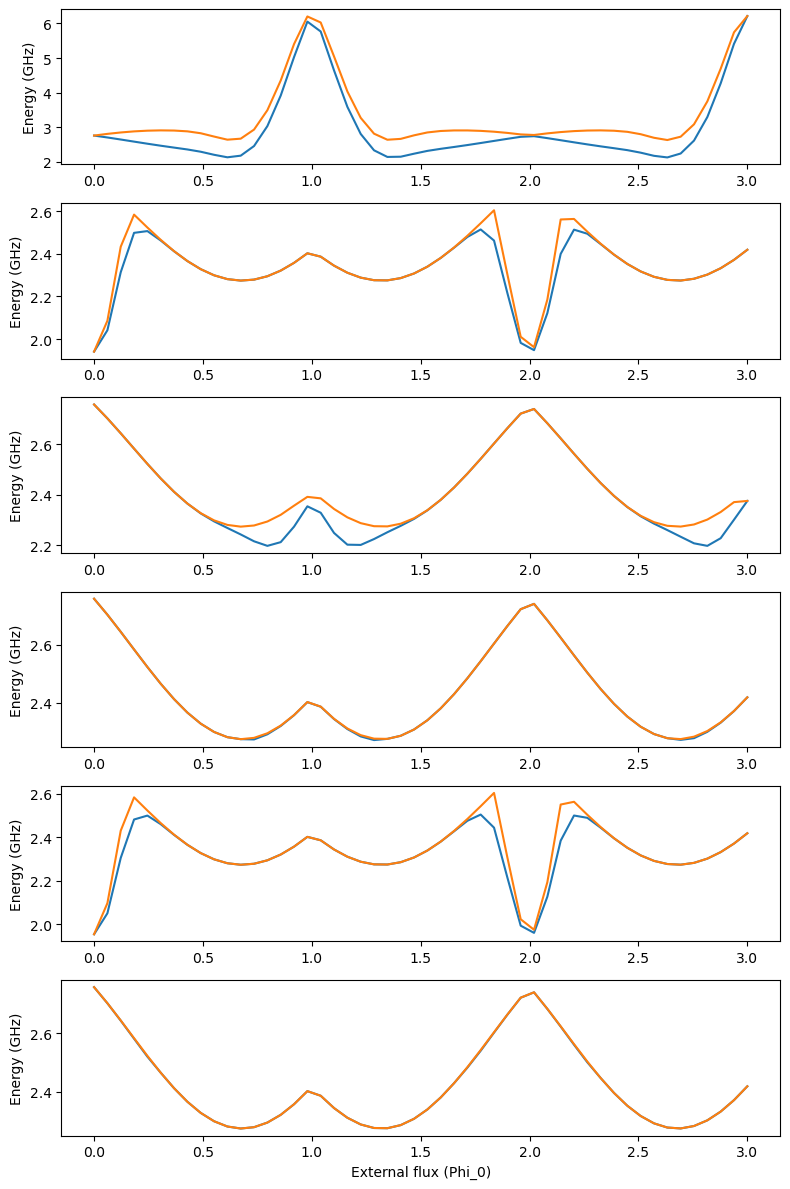

In [224]:
# plot the eigenvalues  of the function above
Ec = 0.284e9
Eo = 0.190e9
Ej = 12.5e9
e_SO = [0, 0, 0.300e9]
eigvals = 6

phi_ext_list = np.linspace(0,3*np.pi,50)
evals_list_charge = np.zeros((len(phi_ext_list),eigvals))
evals_list_fock = np.zeros((len(phi_ext_list),eigvals))
ekets_list = []
N_list = np.arange(10,300,50)

fig,ax = plt.subplots(len(N_list),1,figsize=(8,12))

for j,N in enumerate(tqdm(N_list)):
    for i, phi_ext in enumerate(phi_ext_list):
        # evals_c,ekets_c = eigensystem_gatemon_odd(Ec,Eo,Ej,e_SO,phi_ext, N = 7, eigvals = eigvals)
        evals_f,ekets_f = eigensystem_fbq_odd(Ec,Eo,Ej,e_SO,phi_ext, N = N, eigvals = eigvals)
        evals_list_fock[i,:] = np.real(evals_f) 
    
    ax[j].plot(phi_ext_list/np.pi,evals_list_fock[:,:2]/1e9,label='N = {}'.format(N))
    ax[j].set_ylabel('Energy (GHz)')

ax[-1].set_xlabel('External flux (Phi_0)')
plt.tight_layout()
plt.show()

# phi_ext_list = np.concatenate([-phi_ext_list[::-1][0:-1],phi_ext_list])
# evals_list_charge = np.concatenate([evals_list_charge[::-1][0:-1],evals_list_charge])
# evals_list_fock = np.concatenate([evals_list_fock[::-1][0:-1],evals_list_fock])


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


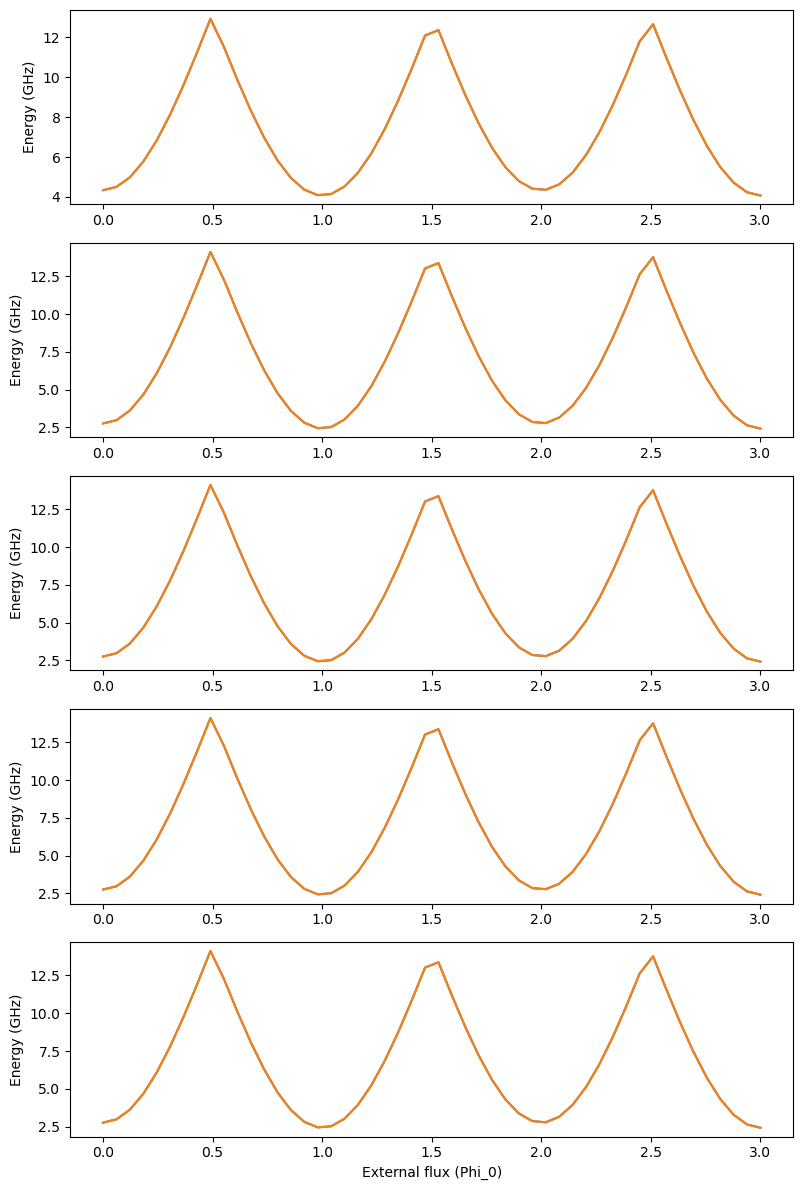

In [227]:
# plot the eigenvalues  of the function above
Ec = 0.284e9
Eo = 0.190e9
Ej = 12.5e9
e_SO = [0, 0, 0.300e9]
eigvals = 6

phi_ext_list = np.linspace(0,3*np.pi,50)
evals_list_charge = np.zeros((len(phi_ext_list),eigvals))
evals_list_fock = np.zeros((len(phi_ext_list),eigvals))
ekets_list = []
N_list = np.arange(1,25,5)

fig,ax = plt.subplots(len(N_list),1,figsize=(8,12))

for j,N in enumerate(tqdm(N_list)):
    for i, phi_ext in enumerate(phi_ext_list):
        # evals_c,ekets_c = eigensystem_gatemon_odd(Ec,Eo,Ej,e_SO,phi_ext, N = 7, eigvals = eigvals)
        evals_f,ekets_f = eigensystem_gatemon_odd(Ec,Eo,Ej,e_SO,phi_ext, N = N, eigvals = eigvals)
        evals_list_fock[i,:] = np.real(evals_f) 
    
    ax[j].plot(phi_ext_list/np.pi,evals_list_fock[:,:2]/1e9,label='N = {}'.format(N))
    ax[j].set_ylabel('Energy (GHz)')

ax[-1].set_xlabel('External flux (Phi_0)')
plt.tight_layout()
plt.show()

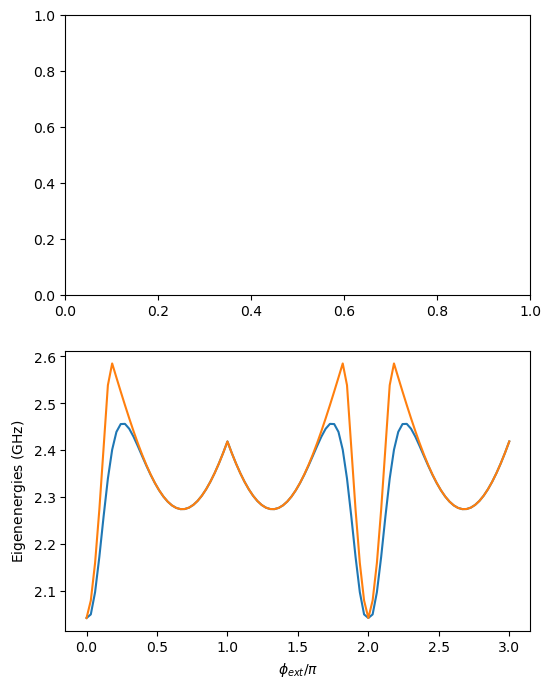

In [219]:
fig,ax = plt.subplots(2,1,figsize=(6,8))
# for i in range(eigvals):
#     ax[0].plot(phi_ext_list/np.pi,evals_list[:,i]/1e9)

# ax[0].plot(phi_ext_list/np.pi,(evals_list_charge[:,:])/1e9)
ax[1].plot(phi_ext_list/np.pi,(evals_list_fock[:,:2])/1e9)
ax[1].set_xlabel(r'$\phi_{ext}/\pi$')
ax[1].set_ylabel(r'Eigenenergies $\mathrm{(GHz)}$')

plt.show()